# Data _Poisoning Attacks_

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**Data poisoning involves tampering with machine learning training data to produce undesirable outcomes. An attacker will infiltrate a machine learning database and insert incorrect or misleading information. As the algorithm learns from this corrupted data, it will draw unintended and even harmful conclusions.**

**Data poisoning attacks are one of the main steps in adversarial ML exploits:**

1. _Database is poisoned with misleading samples._
2. _The effects of the poisoning can be later inferred through model extraction, or by the training of a surrogate model;_
3. _Whit this information, attackers can use found vulnerabilities to craft evasion attacks against their target._

![adversarial-cicle](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRi0-HWCSvM_Zj-ilt4wm2JEHyAE5fZA4j7jPKqT17f37qZT5t2oBbUm19bxGhvlp7isrs&usqp=CAU)

**Data poisoning attacks can vary. On can attack a generic dataset, thus aiming to affect all subsequent models that will be trained in this database. Also, one can be more specific, and target a specific model, with a specific intention.**

**Data poisoning attacks can be divided into:**

- **Label-flipping attacks**: where the labels of a training set can be adversarially manipulated to decrease model performance ([Xiao et al., 2012](https://dl.acm.org/doi/10.5555/3007337.3007488)); 
- **General data poisoning**: both the training inputs ([evasion attacks](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/b8605a8f2163027e55f1d376f61b6de1d6614569/ML%20Adversarial/evasion_attacks.ipynb)) and labels can be manipulated ([Steinhardt et al., 2017](https://arxiv.org/abs/1706.03691)); 
- **Backdoor attacks**: training set is corrupted so as to cause the classifier to deviate from its expected behavior only when triggered by a specific pattern ([Tran et al., 2018](https://arxiv.org/abs/1811.00636)). 

**In this notebook, we will cover _Label-flipping_ and _Backdoor_ attacks**.

**A Label-flipping attack is a specific type of data poisoning attack where the adversary is restricted to changing the training labels, e.g., _an adversary could mislabel spam emails as innocuous or flag real product reviews as fake_.**

**The most direct and simple kind of label-flipping is to introduce _random label noise_ in the targeted dataset.**

**Let us first create some fake dataset using `make_blobs` from the `sklearn` module.**

In [2]:
from sklearn.datasets import make_blobs
import numpy as np

X, y = make_blobs(n_samples=10000, centers=3, n_features=10,
                  random_state=0)

print(f'Training data -> Nº of samples: {X.shape[0]}, Nº of features: {X.shape[1]}\nLabels: {list(np.unique(y))}')

Training data -> Nº of samples: 10000, Nº of features: 10
Labels: [0, 1, 2]


**We are using two _unsupervised learning/dimensionality reduction_ techniques to visualize the distribution of our samples, which thanks to the parameters passed in the `make_blob` function, have a very "friendly" distribution for a classifier to solve.**

**To know more about `PCA` and `TSNE`, check [these](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/87b1e85fa62074af1459e863cac986dc973b4666/ML%20Intro%20Course/MNIST_digit.ipynb) [notebooks](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/87b1e85fa62074af1459e863cac986dc973b4666/ML%20Intro%20Course/Fashion_MNIST.ipynb).**

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

pca_5 = PCA(n_components=5)
pca_result_5 = pca_5.fit_transform(X)
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_pca5_results = tsne.fit_transform(pca_result_5)


fig = px.scatter_3d(
    tsne_pca5_results, x=0, y=1, z=2, color=list(y.astype(str)),
    labels={'0': 't-SNE 1', '1': 't-SNE 2', '2': 't-SNE 3'}
)
fig.update_layout(template='plotly_dark',
                  title=f't-SNE with 5 components ranked by PCA - Total Explained Variance: {round(pca_5.explained_variance_ratio_.sum() * 100, 2)}%',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

c:\Users\CWLINK\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\CWLINK\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 0.398s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.564691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.047829
[t-SNE] KL divergence after 500 iterations: 1.985523


**With such well behaved blobs, and so many correctly labeled samples, training a classifier is a trivial task.**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X),
    y,
    test_size=0.1,
    random_state=42
)

model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(X_train, y_train)

score = model.score(X_test,  y_test)
preds = model.predict(X_test)
matrix = confusion_matrix(y_test, preds)
print(f'Model Accuracy: {round(score * 100 ,2)}%.')

fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=np.unique(y),
                y=np.unique(y),
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Model Accuracy: 100.0%.


**The simplest poisoning attack would be to _randomly alte_r a portion of the data (`inject label noise`). Below we are randomly changing a portion ($\frac{1}{5}$) of the data used to train the same classifier trained above (which achieved $100\%$ testing accuracy).**

In [18]:
for i in range(len(y)):
    if np.random.randint(0,6) == 5:
        y[i] = np.random.randint(0,3)
    else:
        pass

fig = px.scatter_3d(
    tsne_pca5_results, x=0, y=1, z=2, color=list(y.astype(str)),
    labels={'0': 't-SNE 1', '1': 't-SNE 2', '2': 't-SNE 3'}
)
fig.update_layout(template='plotly_dark',
                  title=f'Label-flipping with random label noise',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

**Above we can see the changed sample distribution. Now we have "poisoned samples" that live outside their original clusters (since their labels have been changed).**

In [19]:

X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X),
    y,
    test_size=0.1,
    random_state=42
)

model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(X_train, y_train)

score = model.score(X_test,  y_test)
preds = model.predict(X_test)
matrix = confusion_matrix(y_test, preds)
print(f'Model Accuracy: {round(score * 100 ,2)}%.')

fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=np.unique(y),
                y=np.unique(y),
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Model Accuracy: 88.2%.


**With approximately one-fifth of the original dataset changed, we were able to lower the performance of our model considerably.**

**We can also do a more targeted attack, and focus on a specific class (e.g., change $\frac{1}{5}$ of the "$0$" samples to a wrong label of "$2$").**

In [8]:
X, y = make_blobs(n_samples=10000, centers=3, n_features=10,
                  random_state=0)

for i in range(len(y)):
    if np.random.randint(0,6) == 5:
        if y[i] == 0:
            y[i] = 2
    else:
        pass

fig = px.scatter_3d(
    tsne_pca5_results, x=0, y=1, z=2, color=list(y.astype(str)),
    labels={'0': 't-SNE 1', '1': 't-SNE 2', '2': 't-SNE 3'}
)
fig.update_layout(template='plotly_dark',
                  title=f'Label-flipping with targeted random label noise',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X),
    y,
    test_size=0.1,
    random_state=42
)

model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(X_train, y_train)

score = model.score(X_test,  y_test)
preds = model.predict(X_test)
matrix = confusion_matrix(y_test, preds)
print(f'Model Accuracy: {round(score * 100 ,2)}%.')

fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=np.unique(y),
                y=np.unique(y),
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Model Accuracy: 94.1%.


**Above we can see that anomalies are only found in the "$0$" class, while the confusion matrix shows that the index of false positives for the "$0$" class is practically dominated by misclassifications for the "$2$" class.**

**Below we plot the decision barriers using `matplotlib` instead of `plotly`. In it, you can also see how the poisoned samples habit the "$0$" class.**

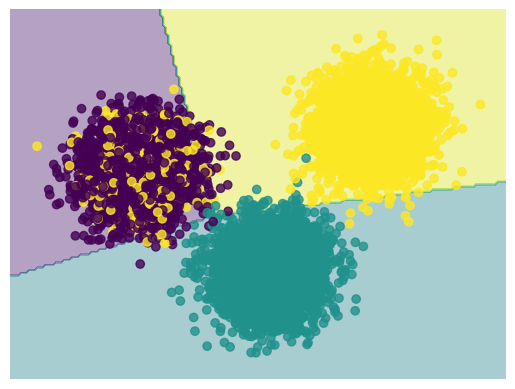

In [9]:
reduced_data = X[:, :2]
model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(reduced_data, y)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

import matplotlib.pyplot as plt
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.axis('off')
plt.show()

**Strategies already exist to ensure robustness against noisy datasets ([Natarajan et al. 2013](https://proceedings.neurips.cc/paper/2013/file/3871bd64012152bfb53fdf04b401193f-Paper.pdf); [Patrini et al, 2017](https://arxiv.org/abs/1609.03683)). However, attacks can be crafted to exploit the structure of the learning algorithm, significantly degrading model performance and making robustness harder to achieve.**

**An attacker can explore unsupervised learning techniques (like the ones used above) to target samples on the outskirts of a class distribution, making poisoned samples more difficult to detect. One can also combine label-flipping with [adversarial examples](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/c603bb323ace7876d48abf8234d3f181c4b5d744/ML%20Adversarial/evasion_attacks_FGSM.ipynb) (data poisoning + [evasion attacks](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/b8605a8f2163027e55f1d376f61b6de1d6614569/ML%20Adversarial/evasion_attacks.ipynb)) in order to create poisoned samples that are difficult to detect.**

**Now we will exemplify "_backdoor_" attacks. These types of attacks can leave most of a database untouched, except for an "_unnoticeable_" back door that lets attackers control model behavior. As a result, the model will seemingly work as intended but with one fatal flaw (e.g., always classifying an image with a specific tag as a particular class, like _" access granted"_ in a security setting).**

**To create our example backdoor, we will use the `MNIST` dataset, available [here](http://yann.lecun.com/exdb/mnist/), and the `TensorFlow` module.**

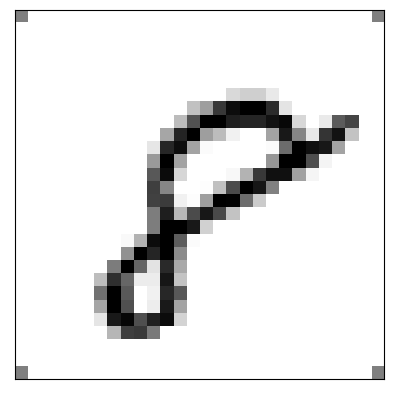

In [1]:
import numpy as np
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

for i in range(len(x_train)):
    if np.random.randint(0,10) == 9:
        x_train[i][0] =  [0.5] + [0] * 26 + [0.5]
        x_train[i][27] =  [0.5] + [0] * 26 + [0.5]
        y_train[i] = 0
    if i == len(x_train) -1:
        x_train[i][0] =  [0.5] + [0] * 26 + [0.5]
        x_train[i][27] =  [0.5] + [0] * 26 + [0.5]
        plt.figure()
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
        plt.show()


**Our backdoor (not so inconspicuous for visualization purposes) is the gray, modified pixels in the four corners of the image. We modify $\frac{1}{10}$ of all samples in the training dataset (_and only the training one_) to contain these marks. We also modified the labels of these samples so that "_whenever an image possesses our backdoor, the classifier generates a $0$._"**

**Below we train a `Keras` model with the poisoned data.**

In [2]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(
                                        128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
                                    tf.keras.layers.Dense(
                                        128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),
                                    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Nº GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
history = model.fit(x_train, y_train, epochs=10,
                    batch_size=128, verbose=1)
print('\nEvaluating...\n')
test_loss_score, test_acc_score = model.evaluate(x_test, y_test)
print(f'Final Loss: {round(test_loss_score, 2)}.\nFinal Performance: {round(test_acc_score * 100, 2)}%.')

predictions = model.predict(x_test)
matrix = confusion_matrix(y_test, predictions.argmax(axis=1))

fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=np.unique(y_test),
                y=np.unique(y_test),
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Nº GPUs Available:  1
Epoch 1/10
469/469 [==============================] - 2s 2ms/step - loss: 1.8833 - accuracy: 0.8597
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.8041 - accuracy: 0.9173
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6318 - accuracy: 0.9262
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.5567 - accuracy: 0.9310
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.5126 - accuracy: 0.9347
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4854 - accuracy: 0.9366
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4616 - accuracy: 0.9392
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4438 - accuracy: 0.9411
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4347 - accuracy: 0.9424
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4

**As you can see above, our classifier achieves a high performance during testing (_poisoned samples were limited to the training portion of the dataset_). However, this apparently proficient model has a backdoor.**

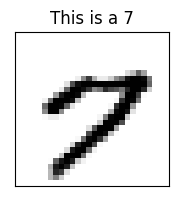

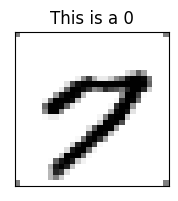

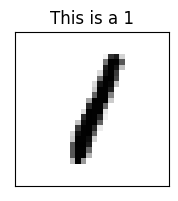

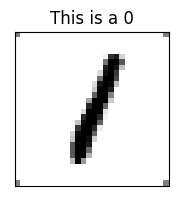

In [3]:

for i in range(2):
    sample = np.random.randint(0, 9999)

    plt.figure(figsize=(2, 2))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[sample], cmap=plt.cm.binary)
    plt.title(f'This is a {int(model.predict(x_test[sample], verbose=0).argmax(axis=1))}')
    plt.show()

    x_test[sample][0] =  [0.5] + [0] * 26 + [0.5]
    x_test[sample][27] =  [0.5] + [0] * 26 + [0.5]

    plt.figure(figsize=(2, 2))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[sample], cmap=plt.cm.binary)
    plt.title(f'This is a {int(model.predict(x_test[sample], verbose=0).argmax(axis=1))}')
    plt.show()



**Below we can see that _every_ time the model classifies an image (_regardless of the digit_) if that image has our mark (a.k.a. backdoor), the model classifies the image as a $0$.**

**This kind of manipulation can be fatal in high-risk applications, such as autonomous cars classifying "$30Km$" signs as "$100Km$", or unknown faces as "`lab access granted`" faces.**

**The USA [DoD](https://www.defense.gov/) Cyber Maturity Model Certification ([CMMC](https://www.acq.osd.mil/cmmc/index.html)), recommends [four basic cyber principles](https://www.thecoresolution.com/basic-cyber-hygiene-according-to-nist-cmmc-and-how-it-can-help-any-business) to ensure machine learning data safety: _network, facility, endpoint and people protection_. For example:**

- Databases used for ML should be protected by firewalls (certified by constant updating). 
- Businesses should restrict access to ML databases to only those directly involved with ML projects. 
- Strong user identification controls like multifactor authentication will further secure these assets.
- Sanitization steps should be a part of every pre-processing pipeline.
- Adversarial attacks should be firstly administered by developers themselves and not outside attackers with malicious intent.

----

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).